In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import streamlit as st
from PIL import Image
from streamlit_drawable_canvas import st_canvas
import numpy as np
from prophet import Prophet

# Step 1: Load and Preprocess Data
# Load each dataset
deal_terms_df = pd.read_csv('All Deal Terms.csv')
conversion_df = pd.read_csv('Stream-Dollar Conversion by Offer ID + Configuration.csv')
luminate_df = pd.read_csv('Luminate Data (All Deals).csv')

In [2]:
# Rename columns
luminate_df['Start Day'] = pd.to_datetime(luminate_df['Start Day'], format="%m/%d/%y", errors='coerce')
luminate_df['End Day'] = pd.to_datetime(luminate_df['End Day'], format="%m/%d/%y", errors='coerce')

luminate_df.rename(columns={
    'Offer ID': 'offer_id',
    'Company ID': 'company_id',
    'Artist ID': 'artist_id',
    'Global Streams': 'global_streams',
    'Week ID': 'week_id',
    'Start Day': 'start_day',
    'End Day': 'end_day'
}, inplace=True)

# Sort by offer_id first, then by start_day within each offer_id
luminate_df = luminate_df.sort_values(by=['offer_id', 'start_day'])

luminate_df.head()

,offer_id,company_id,artist_id,global_streams,week_id,start_day,end_day
13352,6,23,147,177612.0,202042,2020-10-16,2020-10-22
13353,6,23,147,286638.0,202043,2020-10-23,2020-10-29
13354,6,23,147,426713.0,202044,2020-10-30,2020-11-05
13355,6,23,147,738590.0,202045,2020-11-06,2020-11-12
13356,6,23,147,1066978.0,202046,2020-11-13,2020-11-19


In [3]:
# Rename columns in All Deal Terms
deal_terms_df.rename(columns={
    'Offer ID': 'offer_id',
    'In-pocket Advance Amount': 'in_pocket_advance',
    'Marketing Advance Amount': 'marketing_advance',
    'Creative Advance Amount': 'creative_advance',
    'Total Advance Amount': 'total_advance',
    'Artist Pre-Recoupment Split': 'artist_pre_recoup_split',
    'Partner Pre-Recoupment Split': 'partner_pre_recoup_split',
    'Artist Post-Recoupment Split': 'artist_post_recoup_split',
    'Partner Post-Recoupment Split': 'partner_post_recoup_split',
    'Term Length': 'term_length',
    'Date Signed': 'date_signed'
}, inplace=True)

deal_terms_df.head()

,offer_id,in_pocket_advance,marketing_advance,creative_advance,total_advance,artist_pre_recoup_split,partner_pre_recoup_split,artist_post_recoup_split,partner_post_recoup_split,term_length,date_signed
0,6.0,0.0,100000.0,0.0,100000.0,0.0,100.0,70.0,30.0,72.0,10/18/20
1,7.0,5000.0,20000.0,0.0,25000.0,25.0,75.0,75.0,25.0,60.0,10/22/20
2,10.0,10000.0,25000.0,0.0,35000.0,25.0,75.0,75.0,25.0,60.0,12/22/20
3,12.0,5000.0,28813.5,0.0,33813.5,25.0,75.0,75.0,25.0,60.0,2/10/21
4,15.0,5000.0,10000.0,0.0,15000.0,0.0,100.0,70.0,30.0,60.0,1/20/21


In [4]:
# Rename columns in Stream-Dollar Conversion by Offer ID + Configuration
conversion_df.rename(columns={
    'Offer ID': 'offer_id',
    'Units': 'units',
    ' Gross Amount ': 'gross_amount',
    'Configuration': 'configuration'
}, inplace=True)

conversion_df['gross_amount'] = conversion_df['gross_amount'].str.replace(r'[\$,]', '', regex=True).str.strip()

conversion_df.head()

,offer_id,units,gross_amount,configuration
0,283.000,4.0,1.55,Download
1,555.000,26572.0,168.02,Premium Stream
2,68.000,8.0,0.07,Video Stream
3,292.291,977.0,6.80,Premium Stream
4,496.000,2.0,1.47,Download


In [5]:
def display_offer_details(offer_id):
    # Filter Deal Terms for the given offer_id
    deal_terms = deal_terms_df[deal_terms_df['offer_id'] == offer_id]
    if deal_terms.empty:
        print(f"No deal terms found for Offer ID {offer_id}.")
    else:
        print(f"Deal Terms for Offer ID {offer_id}:")
        print(deal_terms)
        print("\n")

    # Filter Streaming to Dollar Conversion for the given offer_id
    conversion_data = conversion_df[conversion_df['offer_id'] == offer_id]
    if conversion_data.empty:
        print(f"No streaming to dollar conversion rate found for Offer ID {offer_id}.")
    else:
        print(f"Streaming to Dollar Conversion for Offer ID {offer_id}:")
        print(conversion_data)
        print("\n")

    # Filter Weekly Streaming Data for the given offer_id
    streaming_data = luminate_df[luminate_df['offer_id'] == offer_id]
    if streaming_data.empty:
        print(f"No weekly streaming data available for Offer ID {offer_id}.")
    else:
        print(f"Weekly Streaming Data for Offer ID {offer_id}:")
        print(streaming_data[['start_day', 'end_day', 'global_streams']])
        print("\n")

# Example usage
display_offer_details(37)

Deal Terms for Offer ID 37:
   offer_id  in_pocket_advance  marketing_advance  creative_advance  \
6      37.0                0.0             5000.0               0.0   

   total_advance  artist_pre_recoup_split  partner_pre_recoup_split  \
6         5000.0                     75.0                      25.0   

   artist_post_recoup_split  partner_post_recoup_split  term_length  \
6                      75.0                       25.0         18.0   

  date_signed  
6     4/14/21  


Streaming to Dollar Conversion for Offer ID 37:
     offer_id        units gross_amount     configuration
68       37.0  113360342.0     25367.82  Ad Funded Stream
119      37.0  624565482.0      3561.96               UGC
155      37.0      19166.0       517.50             Other
224      37.0          3.0         0.01      Video Stream
314      37.0      21249.0      1723.51            Stream
461      37.0        689.0       323.06          Download
784      37.0   19981774.0     65522.82    Premium Stre

In [6]:
def calculate_conversion_rate(offer_id):
    # Filter the conversion data for the given offer_id
    stream_conversion = conversion_df[conversion_df['offer_id'] == float(offer_id)]
    if stream_conversion.empty:
        print(f"No conversion data found for Offer ID {offer_id}.")
        return None

    stream_conversion = stream_conversion[stream_conversion['configuration'].str.contains('Stream')]

    if stream_conversion.empty:
        print(f"No conversion data with 'Stream' configuration found for Offer ID {offer_id}.")
        return None

    # Ensure 'gross_amount' and 'units' are numeric
    stream_conversion['gross_amount'] = pd.to_numeric(stream_conversion['gross_amount'], errors='coerce')
    stream_conversion['units'] = pd.to_numeric(stream_conversion['units'], errors='coerce')

    # Drop rows with invalid data
    stream_conversion = stream_conversion.dropna(subset=['gross_amount', 'units'])
    
    if stream_conversion.empty:
        print(f"No valid conversion data with 'Stream' configuration found for Offer ID {offer_id}.")
        return None

    # Calculate conversion rate for each row
    stream_conversion['conversion_rate'] = stream_conversion['gross_amount'] / stream_conversion['units']

    # Drop rows with conversion rates outside the valid range
    stream_conversion = stream_conversion[
        (stream_conversion['conversion_rate'] >= 0.001) & (stream_conversion['conversion_rate'] <= 0.008)
    ]
    
    # Compute the average conversion rate
    average_conversion_rate = stream_conversion['conversion_rate'].mean()

    print(f"Average Conversion Rate (Stream Configuration) for Offer ID {offer_id}: ${average_conversion_rate:.4f} per unit")

calculate_conversion_rate(37)
calculate_conversion_rate(247)

Average Conversion Rate (Stream Configuration) for Offer ID 37: $0.0033 per unit
Average Conversion Rate (Stream Configuration) for Offer ID 247: $0.0048 per unit


In [7]:
def get_streaming_data(offer_id):
    # Filter Weekly Streaming Data for the given offer_id
    streaming_data = luminate_df[luminate_df['offer_id'] == offer_id].copy()
    if streaming_data.empty:
        print(f"No weekly streaming data available for Offer ID {offer_id}.")
        return None, None

    # Ensure start_day is properly formatted
    streaming_data['start_day'] = pd.to_datetime(streaming_data['start_day'])

    # Sort data by start_day for proper time-series continuity
    streaming_data = streaming_data.sort_values(by='start_day')

    # Extract dates and streams as arrays
    dates = streaming_data['start_day'].values
    streams = streaming_data['global_streams'].values

    # Return the dates and streams
    return dates, streams

In [8]:
def prophet_forecast(offer_id, dates, streams):
    # Get deal terms for the given offer_id
    deal_terms = deal_terms_df[deal_terms_df['offer_id'] == offer_id]
    if deal_terms.empty:
        print(f"No deal terms found for Offer ID {offer_id}.")
        return None, None

    # Extract start and end dates from the deal terms
    start_date = pd.to_datetime(deal_terms.iloc[0]['date_signed'])
    term_length_months = deal_terms.iloc[0]['term_length']
    end_date = start_date + pd.DateOffset(months=term_length_months)

    # Ensure no invalid data in streams
    valid_data_mask = ~pd.isnull(streams)
    dates = dates[valid_data_mask]
    streams = streams[valid_data_mask]

    # Create a DataFrame for Prophet
    data = pd.DataFrame({'ds': dates, 'y': streams})

    # Prophet Forecasting
    prophet_model = Prophet()
    prophet_model.fit(data)

    # Validate future_dates range
    forecast_start_date = dates[-1] + pd.Timedelta(weeks=1)
    if end_date <= forecast_start_date:
        print("End date is earlier than or equal to the start of the forecast period. No forecast generated.")
        return None, None

    # Create future dates up to the end date
    future_dates = pd.date_range(start=forecast_start_date, end=end_date, freq='W-SUN')
    future = pd.DataFrame({'ds': future_dates})

    # Generate forecasts
    prophet_forecast = prophet_model.predict(future)['yhat'].values

    # Return the forecasted data
    return future_dates, prophet_forecast

In [9]:
def holt_winters_forecast(offer_id, dates, streams):
    # Get deal terms for the given offer_id
    deal_terms = deal_terms_df[deal_terms_df['offer_id'] == offer_id]
    
    if deal_terms.empty:
        print(f"No deal terms found for Offer ID {offer_id}.")
        return None, None

    # Extract start and end dates from the deal terms
    start_date = pd.to_datetime(deal_terms.iloc[0]['date_signed'])
    term_length_months = deal_terms.iloc[0]['term_length']
    end_date = start_date + pd.DateOffset(months=term_length_months)

    # Ensure no invalid data in streams
    valid_data_mask = ~pd.isnull(streams)
    dates = dates[valid_data_mask]
    streams = streams[valid_data_mask]

    # Ensure a continuous index for Holt-Winters
    training_index = pd.to_datetime(dates)
    streams = pd.Series(streams, index=training_index)

    # Create future dates up to the end date
    future_dates = pd.date_range(start=training_index[-1] + pd.Timedelta(weeks=1), end=end_date, freq='W-SUN')

    # Holt-Winters Forecasting
    holt_model = ExponentialSmoothing(streams, trend='add', seasonal='add', seasonal_periods=12)
    holt_fit = holt_model.fit()
    holt_forecast = holt_fit.forecast(len(future_dates))

    # Return the forecasted data
    return future_dates, holt_forecast

In [10]:
def combined_forecast(offer_id, dates, streams):
    # Step 1: Get forecasts from Holt-Winters and Prophet
    future_dates_hw, holt_forecast = holt_winters_forecast(offer_id, dates, streams)
    future_dates_p, prophet_results = prophet_forecast(offer_id, dates, streams)  # Renamed variable

    # Step 2: Validate alignment of forecast periods
    if future_dates_hw is None:
        print(f"Holt-Winters forecast could not be generated for Offer ID {offer_id}.")
        return None, None
    if future_dates_p is None:
        print(f"Prophet forecast could not be generated for Offer ID {offer_id}.")
        return None, None
    if len(future_dates_hw) != len(future_dates_p):
        print("Forecast periods from Holt-Winters and Prophet do not align.")
        return None, None

    # Step 3: Combine forecasts with weights
    weight_prophet = 0.9
    weight_holt = 0.1
    combined_forecast = (weight_holt * holt_forecast + weight_prophet * prophet_results)

    # Step 4: Return combined forecast and future dates
    return future_dates_hw, combined_forecast

In [29]:
def plot_forecast(offer_id):
    dates, streams = get_streaming_data(offer_id)
    if dates is None or streams is None:
        print("No streaming data available to plot.")
        return

    future_dates, future_streams = combined_forecast(offer_id, dates, streams)
    if future_dates is None or future_streams is None:
        print("No forecast data available to plot.")
        return

    # Plot actual and forecasted data
    plt.figure(figsize=(12, 6))

    # Plot actual data
    plt.plot(dates, streams, label='Actual Data', marker='o', color='blue')

    # Plot forecasted data
    plt.plot(future_dates, future_streams, label='Combined Forecast', linestyle='--', color='orange')

    # Add title and labels
    plt.title(f"Streaming Data and Forecast for Offer ID {offer_id}")
    plt.xlabel("Date")
    plt.ylabel("Global Streams")
    plt.legend()
    plt.grid()
    plt.show()

In [31]:
def plot_actual(offer_id):
    # Retrieve streaming data for the given offer ID
    dates, streams = get_streaming_data(offer_id)
    if dates is None or streams is None:
        print("No streaming data available for Offer ID {}.".format(offer_id))
        return

    # Plot actual streaming data
    plt.figure(figsize=(12, 6))
    plt.plot(dates, streams, label='Actual Data', marker='o', color='blue')

    # Configure plot settings
    plt.title("Actual Streaming Data for Offer ID {}".format(offer_id))
    plt.xlabel("Date")
    plt.ylabel("Global Streams")
    plt.legend()
    plt.grid(True)
    plt.show()

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
02:32:42 - cmdstanpy - INFO - Chain [1] start processing
02:32:42 - cmdstanpy - INFO - Chain [1] done processing


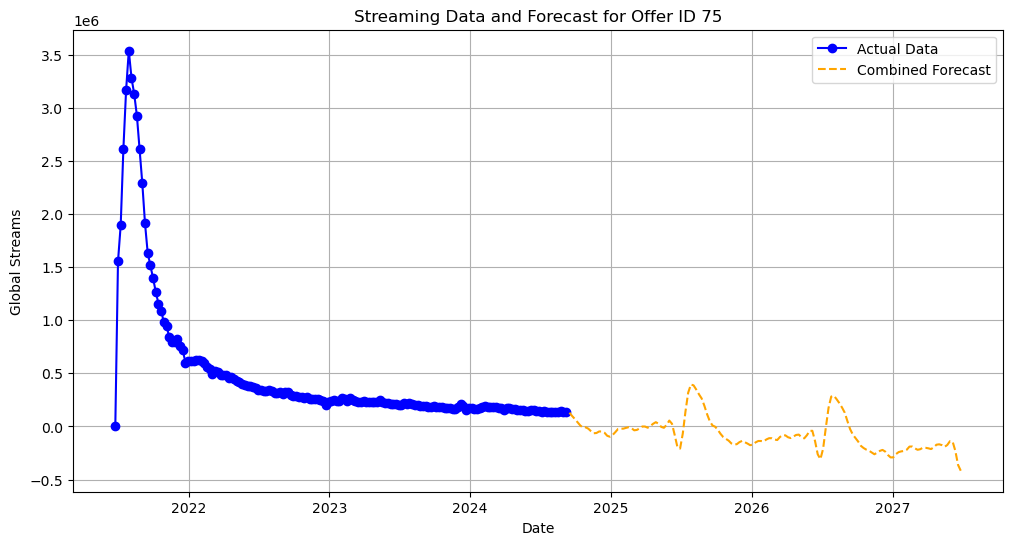

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
02:32:43 - cmdstanpy - INFO - Chain [1] start processing
02:32:43 - cmdstanpy - INFO - Chain [1] done processing


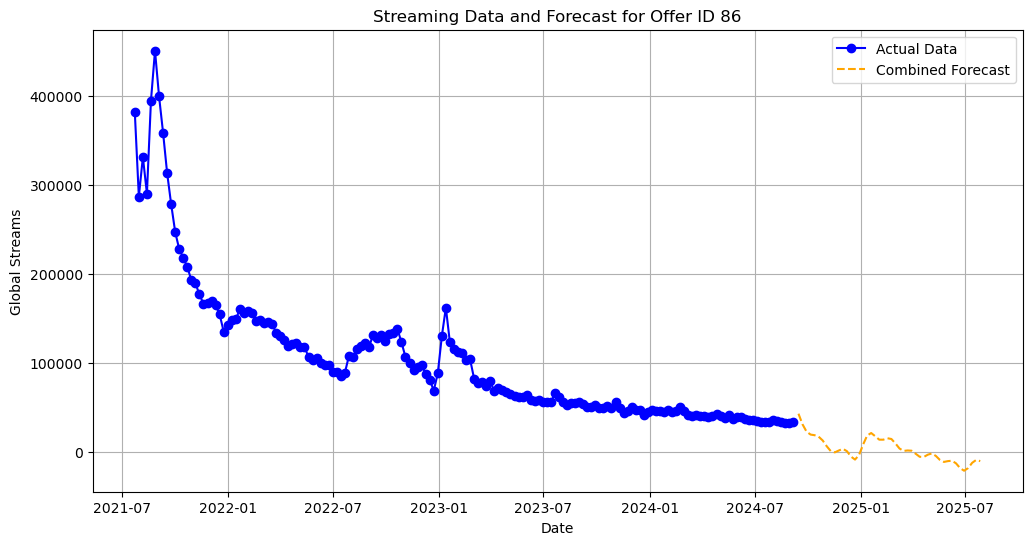

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
02:32:43 - cmdstanpy - INFO - Chain [1] start processing
02:32:43 - cmdstanpy - INFO - Chain [1] done processing


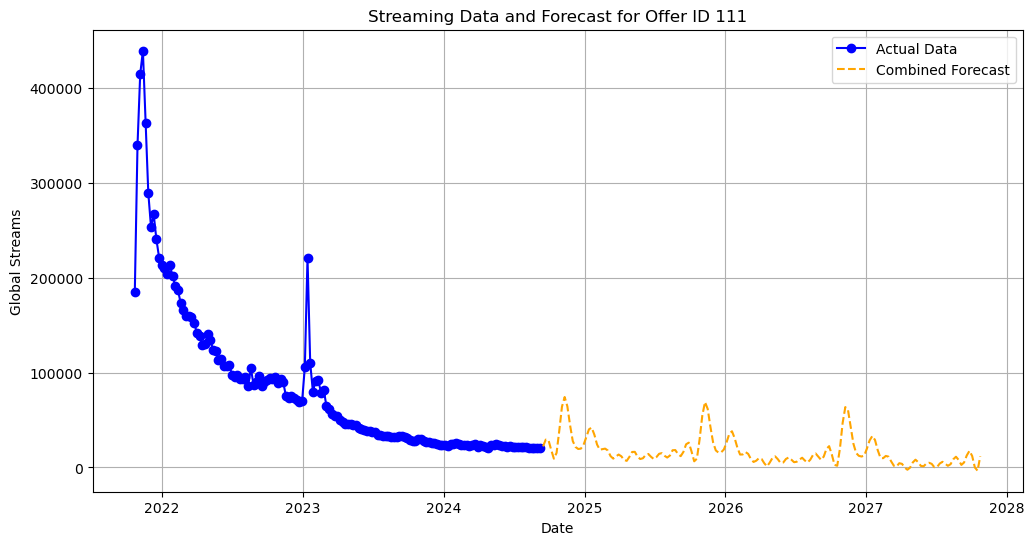

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
02:32:43 - cmdstanpy - INFO - Chain [1] start processing
02:32:43 - cmdstanpy - INFO - Chain [1] done processing


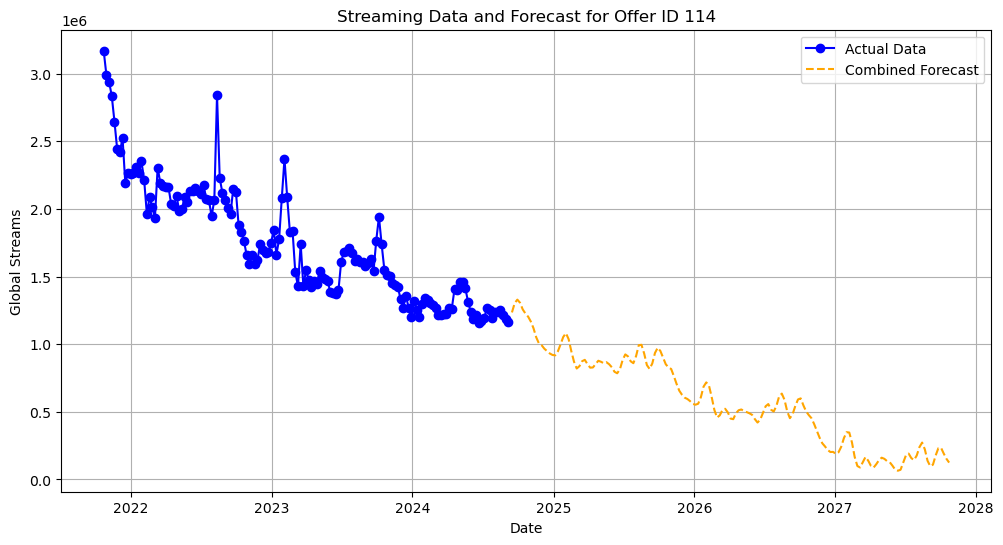

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
02:32:44 - cmdstanpy - INFO - Chain [1] start processing
02:32:44 - cmdstanpy - INFO - Chain [1] done processing


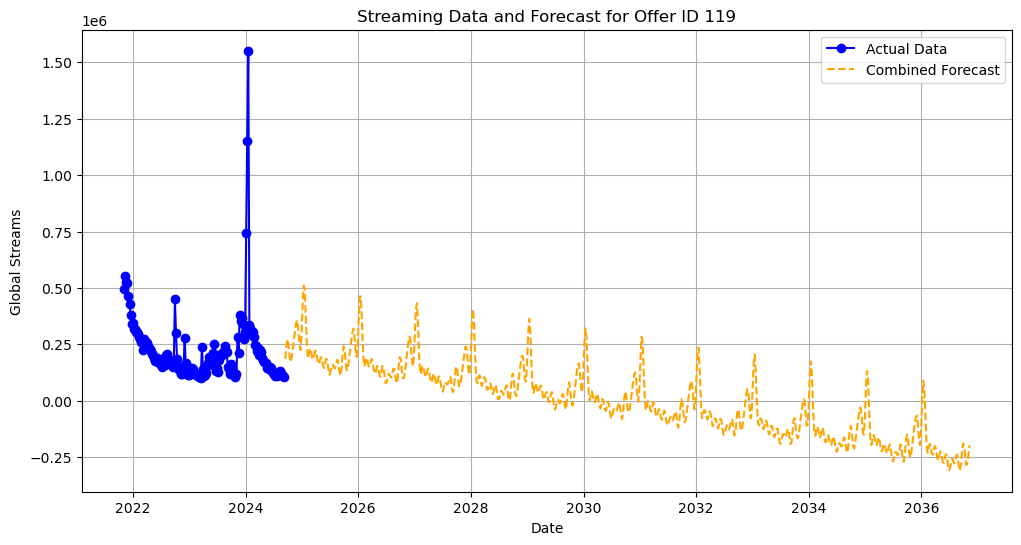

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
02:32:44 - cmdstanpy - INFO - Chain [1] start processing
02:32:4

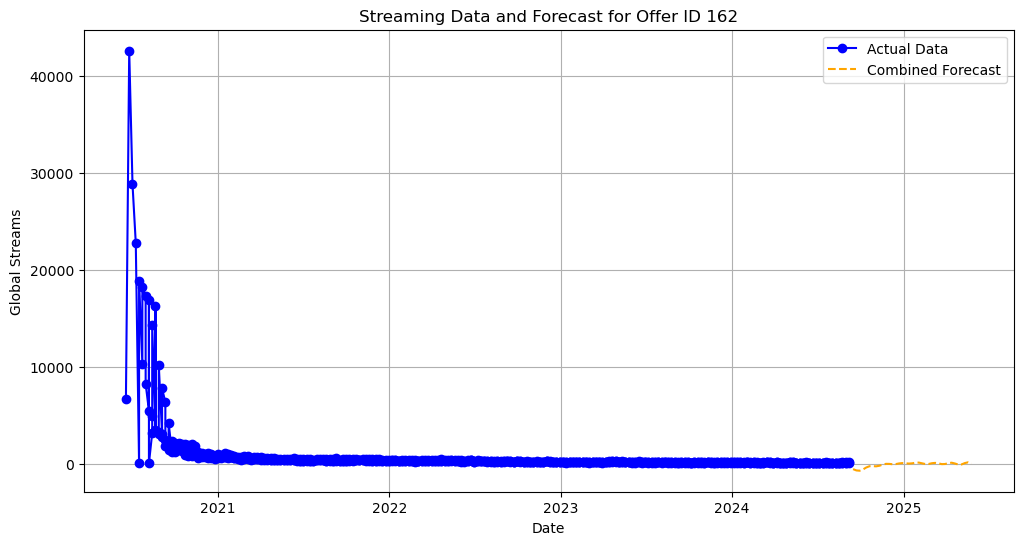

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
02:32:45 - cmdstanpy - INFO - Chain [1] start processing
02:32:45 - cmdstanpy - INFO - Chain [1] done processing


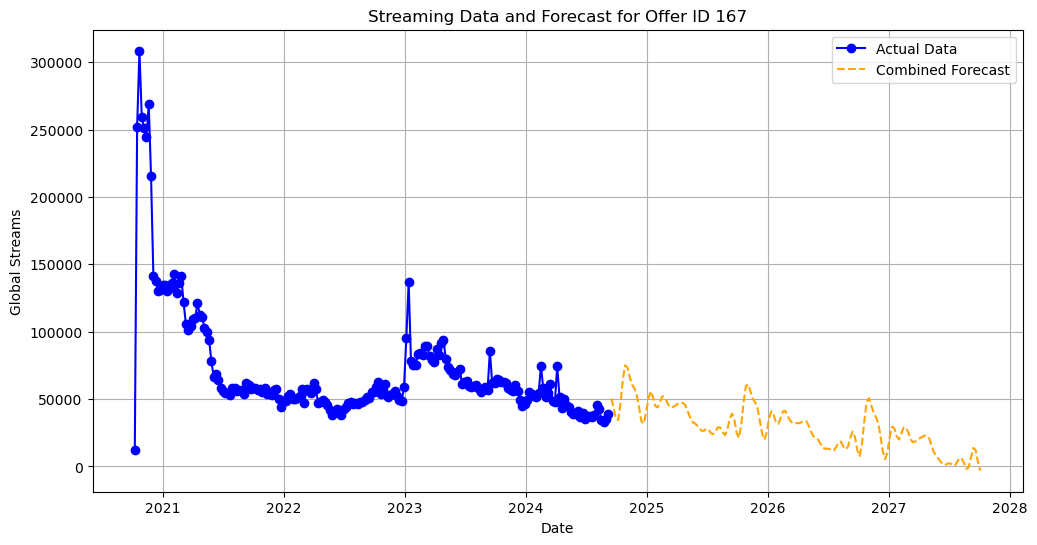

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
02:32:45 - cmdstanpy - INFO - Chain [1] start processing
02:32:45 - cmdstanpy - INFO - Chain [1] done processing


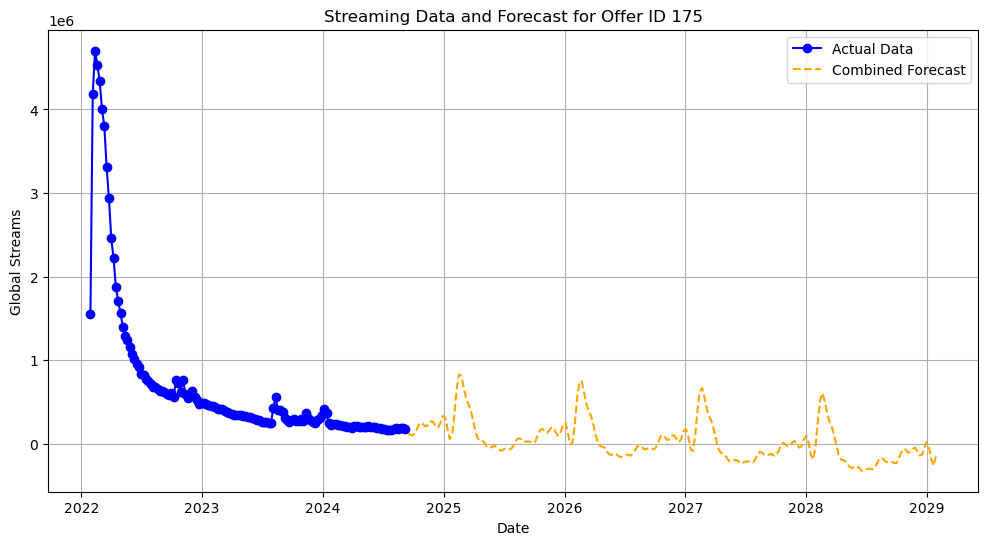

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
02:32:45 - cmdstanpy - INFO - Chain [1] start processing
02:32:45 - cmdstanpy - INFO - Chain [1] done processing


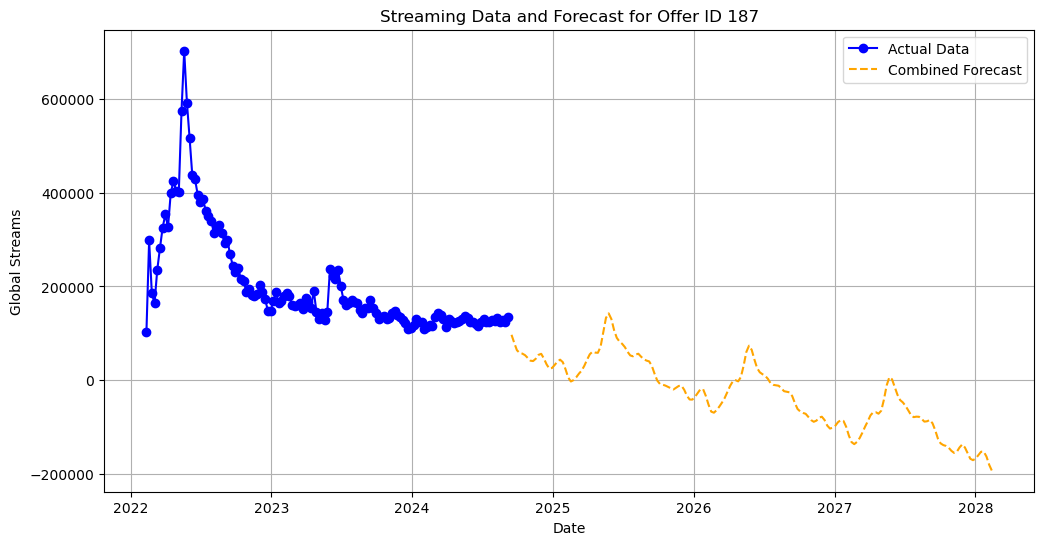

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
02:32:46 - cmdstanpy - INFO - Chain [1] start processing
02:32:46 - cmdstanpy - INFO - Chain [1] done processing


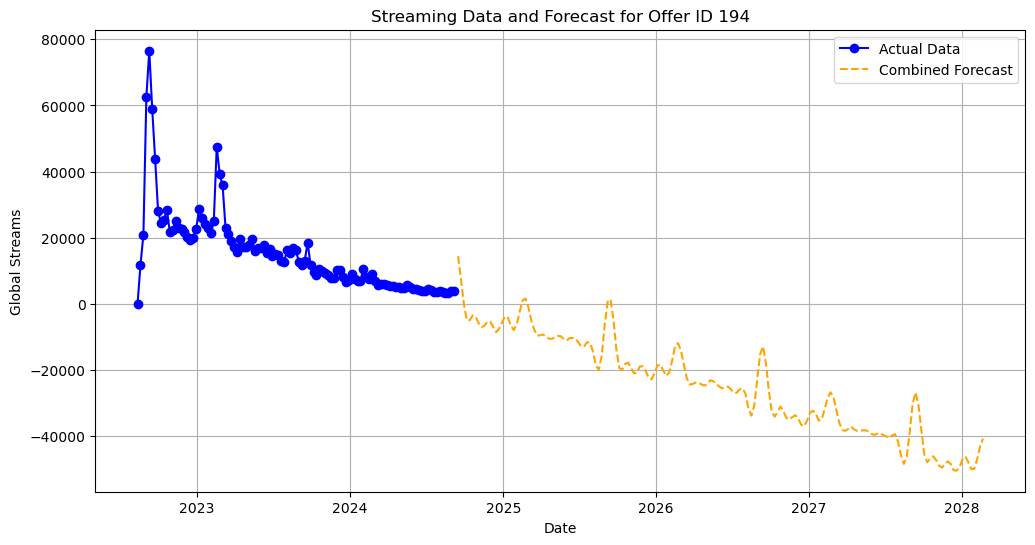

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
02:32:46 - cmdstanpy - INFO - Chain [1] start processing
02:32:46 - cmdstanpy - INFO - Chain [1] done processing


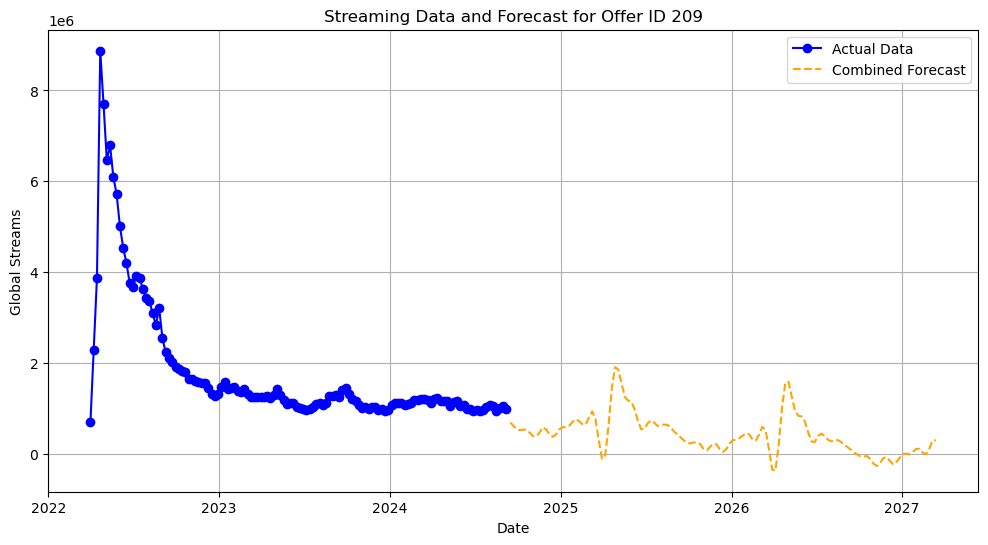

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
02:32:46 - cmdstanpy - INFO - Chain [1] start processing
02:32:46 - cmdstanpy - INFO - Chain [1] done processing


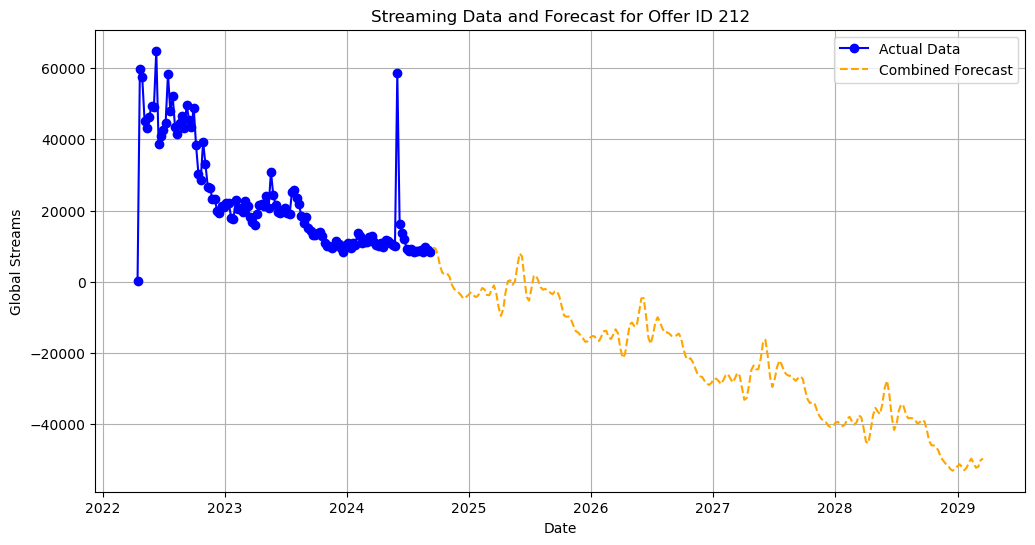

In [33]:
offer_ids = [75, 86, 111, 114, 119, 162, 167, 175, 187, 194, 209, 212]

for offer_id in offer_ids:
    plot_forecast(offer_id)